In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Input, Lambda, Dense, Flatten, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import applications

2024-04-07 06:23:41.115202: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 06:23:41.115305: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 06:23:41.234135: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# gives the list of all directories and subdirectories
train = list(os.walk('/kaggle/input/animals/animals/train')) 

In [3]:
label_names = train[0][1]
dict_labels = dict(zip(label_names, list(range(len(label_names)))))
print(dict_labels)

{'horse': 0, 'lion': 1, 'dog': 2, 'elephant': 3, 'cat': 4}


In [4]:
def dataset(path): # put path till the highest directory level
    images = []
    labels = []
    for folder in tqdm(os.listdir(path)):
    
# dict_labels is the dictionary whose key:value pairs are classes:numbers 
# representing them
        value_of_label = dict_labels[folder] 

        for file in (os.listdir(os.path.join(path, folder))):
            path_of_file = os.path.join(os.path.join(path, folder), file)

            image = cv2.imread(path_of_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (150, 150))
            images.append(image)
            labels.append(value_of_label)

    images = np.array(images, dtype = 'float32')/255.0
    labels = np.array(labels)

    return images, labels

images, labels = dataset('/kaggle/input/animals/animals/train')
images, labels = shuffle(images, labels)

100%|██████████| 5/5 [02:10<00:00, 26.15s/it]


### Number of images of each species

### Sample Images

## Load images using ImageDatagenerator

In [5]:
batch_size = 4 # Number of samples that will be processed in each iteration during training.
test_size = 0.2
train_datagen = ImageDataGenerator(
    rescale = 1./255, 
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/animals/animals/train',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/animals/animals/val',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 13474 images belonging to 5 classes.
Found 1497 images belonging to 5 classes.


## Some Augmented Images

## VGG-16 (Transfer Learning)

In [6]:
from keras.applications import EfficientNetV2M
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

In [7]:
conv_base = EfficientNetV2M(
    weights = 'imagenet',
    include_top = False, # Not including the Dense Layer
    input_shape = (224,224,3)
)

214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


In [8]:
conv_base.trainable = True

In [9]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(120,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(5,activation='softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-m (Functional)   │ ?                      │    53,150,388 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,150,388 (202.75 MB)

 Trainable params: 52,858,356 (201.64 MB)

 Non-trainable params: 292,032 (1.11 MB)

In [10]:
model.compile(optimizer='adamax',loss='categorical_crossentropy',metrics=['accuracy'])

In [11]:
history = model.fit(train_generator,epochs=5,validation_data=test_generator)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1712471541.158894      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   1/3369 ━━━━━━━━━━━━━━━━━━━━ 322:27:37 345s/step - accuracy: 0.0000e+00 - loss: 1.4773

W0000 00:00:1712471541.455683      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3369/3369 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.6333 - loss: 0.9981

W0000 00:00:1712472142.062592      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3369/3369 ━━━━━━━━━━━━━━━━━━━━ 967s 185ms/step - accuracy: 0.6334 - loss: 0.9979 - val_accuracy: 0.7829 - val_loss: 0.5091
Epoch 2/5
3369/3369 ━━━━━━━━━━━━━━━━━━━━ 384s 114ms/step - accuracy: 0.8935 - loss: 0.3190 - val_accuracy: 0.9646 - val_loss: 0.1445
Epoch 3/5
3369/3369 ━━━━━━━━━━━━━━━━━━━━ 385s 114ms/step - accuracy: 0.9271 - loss: 0.2096 - val_accuracy: 0.7809 - val_loss: 0.6061
Epoch 4/5
3369/3369 ━━━━━━━━━━━━━━━━━━━━ 385s 114ms/step - accuracy: 0.9483 - loss: 0.1608 - val_accuracy: 0.9205 - val_loss: 0.3571
Epoch 5/5
3369/3369 ━━━━━━━━━━━━━━━━━━━━ 385s 114ms/step - accuracy: 0.9660 - loss: 0.1018 - val_accuracy: 0.9539 - val_loss: 0.4693


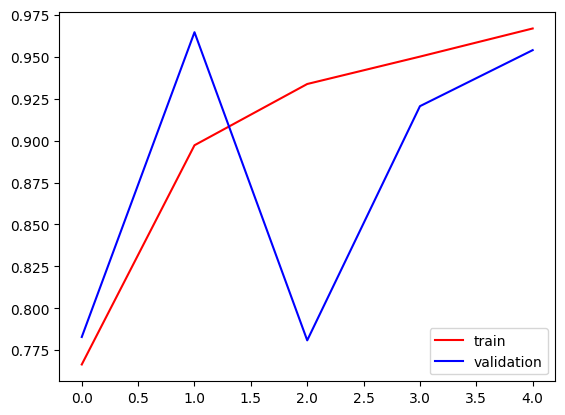

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

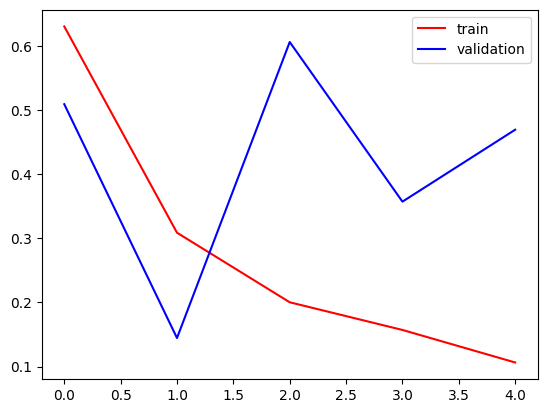

In [13]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

### Saving Model

In [14]:
tf.saved_model.save(model, "EfficientNetV2M")


## Testing our Model

In [15]:
train_generator.class_indices

{'cat': 0, 'dog': 1, 'elephant': 2, 'horse': 3, 'lion': 4}

In [16]:
def predictor(img, model):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.array(image, dtype = 'float32')/255.0
    plt.imshow(image)
    image = image.reshape(1, 224,224,3)
    
    label_names = train_generator.class_indices
    dict_class = dict(zip(list(range(len(label_names))), label_names))
    clas = model.predict(image).argmax()
    name = dict_class[clas]
    print('The given image is of \nClass: {0} \nAnimal: {1}'.format(clas, name))

## Dog Classification

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
The given image is of 
Class: 1 
Animal: dog


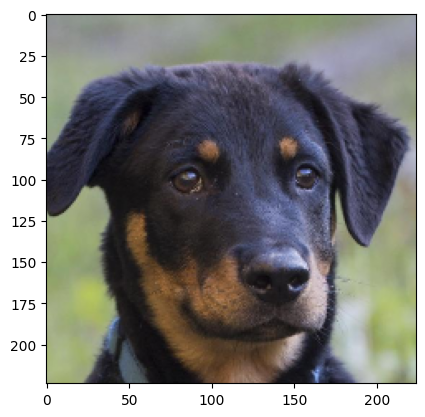

In [17]:
predictor('/kaggle/input/animals/animals/val/dog/dog200.jpg',model)

## Cat Classification

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
The given image is of 
Class: 0 
Animal: cat


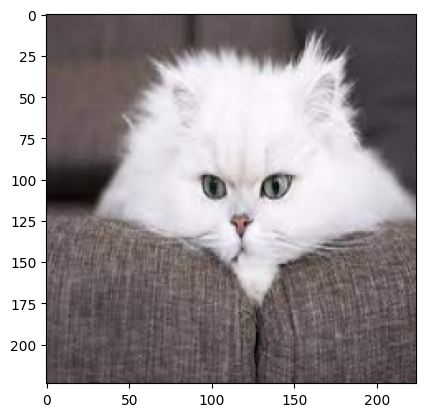

In [18]:
predictor('/kaggle/input/animal-test-v3/cat3.jpg',model)

## Horse Classification

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
The given image is of 
Class: 3 
Animal: horse


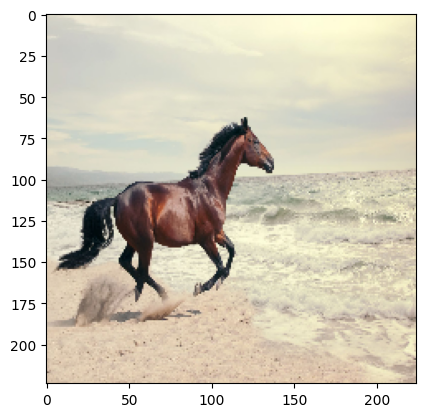

In [19]:
predictor('/kaggle/input/animal-test-v3/horse.jpg',model)

## Lion Classification

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
The given image is of 
Class: 4 
Animal: lion


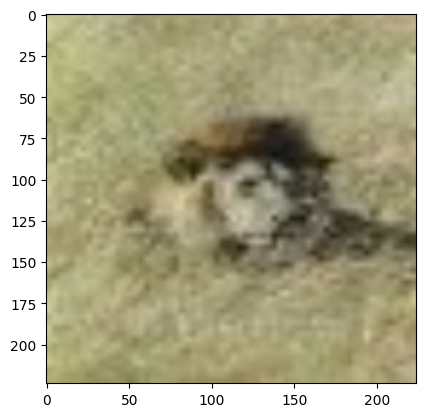

In [20]:
predictor('/kaggle/input/animals/animals/val/lion/lion106.jpg',model)

## Elephant Classification

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
The given image is of 
Class: 2 
Animal: elephant


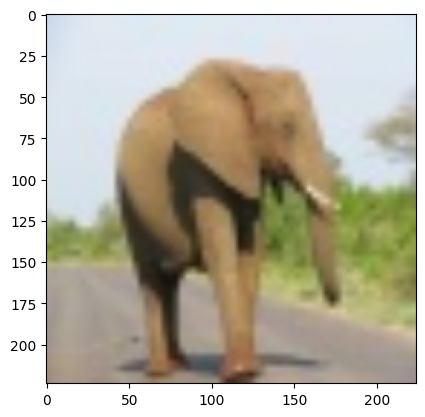

In [21]:
predictor('/kaggle/input/animals/animals/val/elephant/elephant112.jpg',model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
The given image is of 
Class: 2 
Animal: elephant


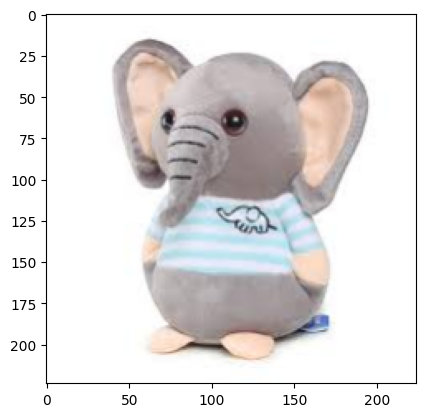

In [22]:
predictor('/kaggle/input/animal-test-v3/elephant_toy.jpg',model)